# Report- Algorithmic Data Science

RegNo: 22316808

# INTRODUCTION

In this report, we're going to look at how we measure the similarity in documents using Jaccard and cosine methods. We'll talk about the ideas behind these methods and see how fast they work. We'll also check out how using Strassen's algorithm and doing many calculations at once can make things faster. The report has five main parts:

1. We'll look at cosine similarity, think about it, try it out, show the results in charts, and see how it does compared to a quick method in NumPy.

2. We'll see how long it takes to figure out Jaccard similarity with different sizes of data and show this with graphs.

3. We'll think about the longest time it could take to use both Jaccard and cosine methods and see which one is faster in the toughest situations.

4. We'll see if doing calculations at the same time speeds things up.

5. We'll try using Strassen's algorithm to see if it can help us do cosine similarity calculations quicker, mixing what we actually see with what we expect to happen.

We'll go through each part one by one so it's easy to understand.

In [1]:
import pandas as pd
import time
import numpy as npy
from numpy.linalg import norm

import matplotlib.pyplot as mplt

import scipy.stats as stats
import math
import os
import threading


In [2]:
 data=pd.read_csv('data2023.csv',  index_col=0)  #Reads the CSV file 'data2023.csv' with the first column set as the row index
                                                                           

In [3]:
display(data.head())   #displays the first 5 entries and the total number of rows and columns of 'data'
print(data.shape)

,doc1,doc2,doc3,doc4,doc5,doc6,doc7,doc8,doc9,doc10,doc11,doc12,doc13,doc14,doc15,doc16,doc17,doc18,doc19,doc20
A,0,6,5,7,9,13,16,12,14,22,17,27,32,17,28,28,47,41,35,32
A-tu,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0
A.,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
ABC,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Aah,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


(21155, 20)


In [4]:
data1=data.iloc[:,0:5] #Selects the first 5 columns of the 'data' and display them
display(data1)
data1.shape #Gets the shape (rows, columns) of the selected data

,doc1,doc2,doc3,doc4,doc5
A,0,6,5,7,9
A-tu,0,0,0,0,0
A.,0,0,0,0,0
ABC,0,0,0,0,1
Aah,0,0,0,0,0
...,...,...,...,...,...
états,0,0,0,0,0
étranger,0,0,0,0,0
évidence.,0,0,0,0,0
êtes,0,0,0,0,0


(21155, 5)

In [5]:
data1=data.iloc[0:2000,:] #Select the first 2000 rows from 'data` and display them
display(data1)

,doc1,doc2,doc3,doc4,doc5,doc6,doc7,doc8,doc9,doc10,doc11,doc12,doc13,doc14,doc15,doc16,doc17,doc18,doc19,doc20
A,0,6,5,7,9,13,16,12,14,22,17,27,32,17,28,28,47,41,35,32
A-tu,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0
A.,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
ABC,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Aah,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Near,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,1,0,1,2
Nearer,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0
Nearest,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Nearly,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0


In [6]:
data_array=data1.values #Converts 'data1' into an array and displays it
print(data_array)

[[ 0  6  5 ... 41 35 32]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


## Question 1  
Our objectives are to examine the computational efficiency of cosine similarity for document comparison. We shall theoretically analyze and empirically test how it works on the novel "War and Peace," timing both manual and NumPy implemented calculations. And we shall compare and establish from our findings which method is more time efficient.

We use 'timeit' function to measure the average time it takes for a given function to run.

In [7]:
def timeit(somefunc,*args,repeats=10,**kwargs):
    times=[]

    while repeats>0:
        starttime=time.time()
        ans=somefunc(*args,**kwargs)
        endtime=time.time()
        timetaken=endtime-starttime
        times.append(timetaken)
        repeats-=1

    mean=npy.mean(times)
    stdev=npy.std(times)

    return (mean,stdev)

Measuring the similarity between two vectors manually using cosine similarity function.

In [8]:
def cosine(doc1,doc2):
  cos_sim = sum(x * y for x, y in zip(doc1, doc2)) / (math.sqrt(sum(x * x for x in doc1)) * math.sqrt(sum(x * x for x in doc2)))
  return cos_sim
cosine(data.iloc[:,0].values,data.iloc[:,1].values)

0.9616845260362251

Measuring cosine similarity through numpy.

In [9]:
def cosine_numpy(vector1,vector2):
    return npy.dot(vector1,vector2)/(norm(vector1)*norm(vector2))

cosine_numpy(data.iloc[:,0].values,data.iloc[:,1].values)
# measuring cosine similarity through numpy.

0.9616845260362251

The code calculates the similarity between two lists of numbers, each representing a document. The closer the result is to 1, the more similar the documents are.

In [10]:
cosine_timelist =[]
for i in range(1000,data.shape[0],100):
    t = timeit(cosine,data.iloc[:i,0].values,data.iloc[:i,1].values,repeats = 20)
    cosine_timelist.append(t[0])
print(cosine_timelist[:5])
   

[0.0003739476203918457, 0.00040053129196166993, 0.0004485011100769043, 0.0003475189208984375, 0.00034880638122558594]



The code runs a test to see how long it takes to calculate the similarity between two documents using the cosine method, repeating this 20 times. From the first five average times output, it is evident that the calculation time increases with more data.

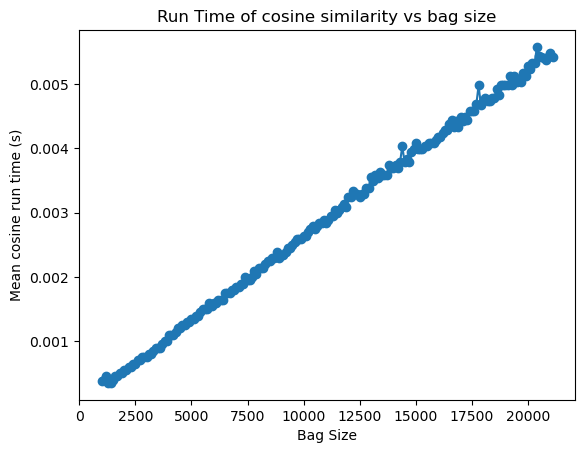

In [11]:
#Ploting the graph of cosine similarity run time VS bag size

%matplotlib inline
x = list(range(1000,data.shape[0],100)) #list of bag size
y = cosine_timelist #times taken to calculate cosine similarity
mplt.scatter(x,y)
mplt.xlabel('Bag Size')
mplt.ylabel('Mean cosine run time (s)')
mplt.title('Run Time of cosine similarity vs bag size')
mplt.plot(x,y)
mplt.show()

In the graph the x-axis shows the amount of data (bag size) and y- axis depicts the time taken to compare the data. The straight line going upward indicates that the time is increasing at constant rate with the gradual increase in the data.

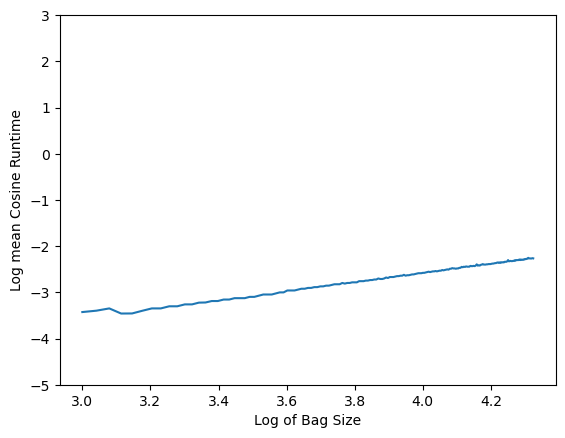

In [13]:
# Taking log of cosine runtime and bag size
logx = [npy.log10(i) for i in x]
logy = [npy.log10(i) for i in y]
# making a graph between log values
mplt.ylim(-5,3)
mplt.plot(logx,logy)
mplt.ylabel("Log mean Cosine Runtime")
mplt.xlabel('Log of Bag Size')
mplt.show()

We use a log scale to run time vs bag size as it simplifies the visual reresentation of an algorithm's time complexity. which helps to keenly observe the pattern of the trend. 

In [14]:
import scipy.stats as stats
res = stats.linregress(logx, logy)
print("Slope is {} and intercept is {}".format(res.slope,res.intercept))

Slope is 0.9777996494390616 and intercept is -6.489468313639458



Here we calculate the slope of the line. The slope is almost 1. This shows that the time to do the calculation grows at the same rate as the size of the data, indicationg a o(n) complexity.  

In [29]:
cosine_numpy_time_list =[]
# In order to record the time for varied document lengths, a pair of documents is passed through the loop, each pair having a different length.
for i in range(1000,data.shape[0],100):
    k =timeit(cosine_numpy,data.iloc[:i,0].values,data.iloc[:i,1].values,repeats = 60)
    cosine_numpy_time_list.append(k[0])
print(cosine_numpy_time_list[:5])
print(npy.mean(cosine_numpy_time_list))


[1.660585403442383e-05, 1.6609827677408855e-05, 1.607338587443034e-05, 1.6748905181884766e-05, 1.6542275746663413e-05]
5.387833016146921e-05


Here we measure the time taken to calculate the similarity between two documents using numpy.

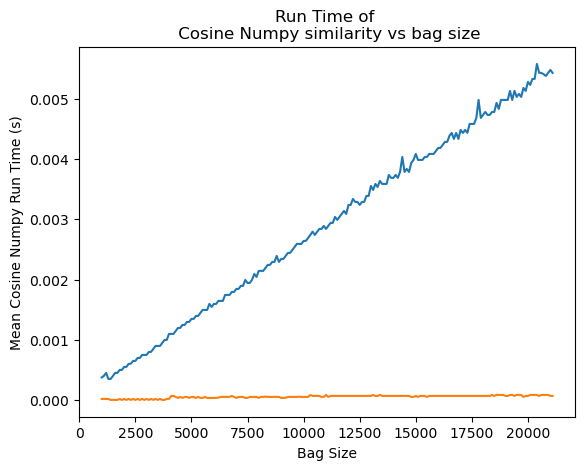

In [16]:
%matplotlib inline
x = list(range(1000,data.shape[0],100)) #list of bag size
y_numpy = cosine_numpy_time_list

mplt.xlabel('Bag Size')
mplt.ylabel('Mean Cosine Numpy Run Time (s)')
mplt.title('Run Time of \n Cosine Numpy similarity vs bag size')
mplt.plot(x,y)
mplt.plot(x,y_numpy)
mplt.show()


The graph displays two lines indicating the time it takes to compute similarity as the amount of data increases. The blue line, which climbs steadily indicates that it takes more time to see how alike two things are for the cosine similarity. In contrast, the flat orange line suggests a numpy methods computation time remains constant regardless of data size.

C:\Users\tg342\AppData\Local\Temp\ipykernel_8196\2567356711.py:3: RuntimeWarning: divide by zero encountered in log10
  logy = [npy.log10(i) for i in y_numpy]


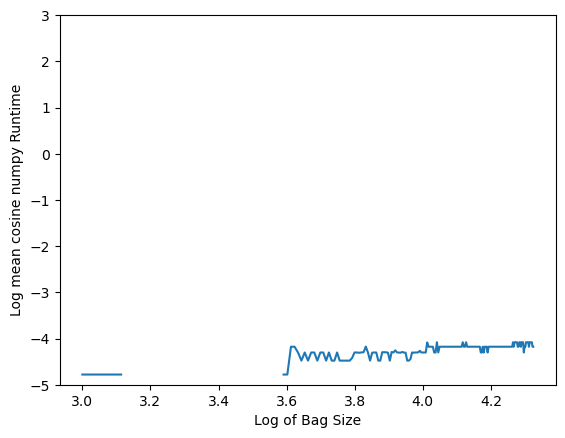

In [17]:
#taking log of cosine numpy runtime and bag size
logx = [npy.log10(i) for i in x]
logy = [npy.log10(i) for i in y_numpy] 
# making a graph between log values
mplt.ylim(-5,3)
mplt.plot(logx,logy)
mplt.ylabel("Log mean cosine numpy Runtime")
mplt.xlabel('Log of Bag Size')
mplt.show()

When tried to plot a a graph of log  of mean cosine numpy runtime vs log of bag size we saw an error as the dataset included a zero, the abrubt graph is because we cant take log of zero. Maybe the time was noted as zero which can't be showed with log

In [211]:
import scipy.stats as stats
res = stats.linregress(logx, logy)
print("Slope is {} and intercept is {}".format(res.slope,res.intercept))

Slope is nan and intercept is nan


C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2699: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


The error from  the graph correlates with the error occured while trying to find a slope and intercept, giving 'nan' (not a number) instruction.

<BarContainer object of 2 artists>

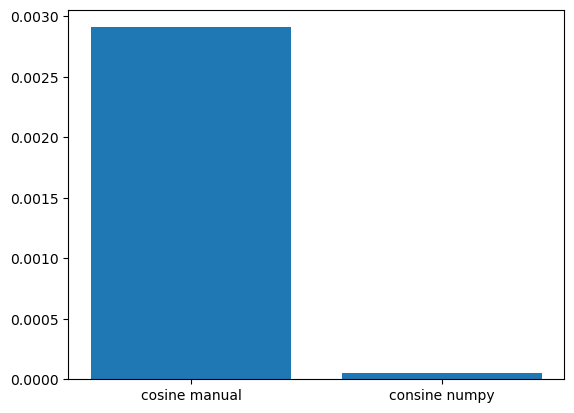

In [18]:
mplt.bar(['cosine manual','consine numpy'],[npy.mean(y),npy.mean(y_numpy)])

The bar chart compares the mean computation times for two methods of determining the cosine similarity,  a manual method and a method that makes use of NumPy library functions. The shorter bar for the NumPy technique implies that it's quicker, indicating that using NumPy is more time efficient than the bigger bar for the manual method, which shows it takes more time on average.

# Question 2
The Jaccard similarity coefficient helps us understand how similar documents are by comparing their content. Our study looks at how fast we can compute this similarity when we have a lot of documents.
 We write some Python code to do this and run it on a big set of document data to see how long it takes. From this, we learn about the factors that can make this computation faster or slower.

In [19]:
def maketotal(dict1):
    total=0                   # Initialize the total sum to zero.
    for item in dict1:        # Iterate over each key-value pair in the dictionary
        total += dict1[item]  # Add the value to the total sum.
    return total              # Return the computed total sum.

In [20]:
def jaccard(dict1,dict2):                 
    intersection={}                       # Creates a dictionary to store the intersection of dict1 and dict2.
    for item in dict1.keys():             # Iterates over the keys in dict1.
        if item in dict2.keys():          # Checks if the current key also exists in dict2.
            intersection[item]=min(dict1[item],dict2[item])  # Adds the key to the intersection with the smaller value from the two dictionaries.

    intersectiontot=maketotal(intersection) # Calculate the total of the intersection dictionary using the maketotal function.
    union = maketotal(dict1)+maketotal(dict2)-intersectiontot # Calculate the total of the intersection dictionary using the maketotal function.
    return intersectiontot/union 

This function computes the jaccard similaritybetween two doccuments using the 'maketotal' function to find the intersection and union sizes of the sets

In [21]:
jaccard(data.iloc[:,0].to_dict(),data.iloc[:,1].to_dict())  # Compute the Jaccard similarity between the first two columns of the DataFrame 'data'

0.5032614604094945

In [256]:
range(1200,data.shape[0],100) # Generate a range of numbers from 1200 to the number of rows in 'data', in steps of 100

range(1200, 2000, 100)

In [22]:
jaccard_time_list =[]    # Initialize an empty list to store the timings for Jaccard similarity calculations
for i in range(1200,data.shape[0],100): # Iterate over a range from 1200 to the number of rows in 'data', in steps of 100
    k =timeit(jaccard,data.iloc[:i,0].to_dict(),data.iloc[:i,1].to_dict(),repeats = 10) # Time the Jaccard similarity calculation for the first 'i' rows in the first two columns of 'data'
                                                                                        # Repeat the timing 10 times for accuracy and store the average time
    jaccard_time_list.append(k[0]) 
print(jaccard_time_list[:5])
print(npy.mean(jaccard_time_list))

[0.0004982471466064454, 0.0005979537963867188, 0.0005980491638183594, 0.0005979299545288086, 0.000399017333984375]
0.003053056836128235


In [258]:
data.shape[0]

2000

In [23]:
def jaccard_numpy(vector1,vector2):  
    #Calculates the cosine similarity between two documents using NumPy's dot product function.
    return npy.sum(npy.minimum(vector1, vector2)) / npy.sum(npy.maximum(vector1, vector2))
    # Return the cosine similarity

In [260]:
range(1200,data.shape[0],100)

range(1200, 2000, 100)

Equation to plot the graph

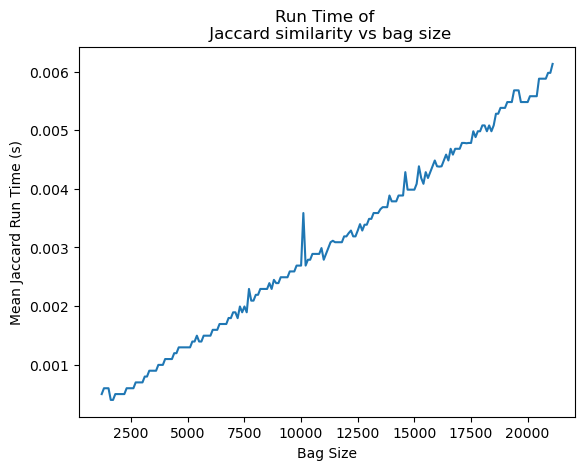

In [24]:
%matplotlib inline
x = list(range(1200,data.shape[0],100))#list of bag size
y = jaccard_time_list

mplt.xlabel('Bag Size')
mplt.ylabel('Mean Jaccard Run Time (s)')
mplt.title('Run Time of \n Jaccard similarity vs bag size')
mplt.plot(x,y)



mplt.show()

The graph depicts the relationship between the size of data set (bag size) and the time taken to compute the jaccard similarity. It is evident from the line growing up that larger datasets require more time to compute the jaccard similarity calculation

We'll now plot the graph to determine the time complexity by taking the log on both sides of the equation in order to do this.


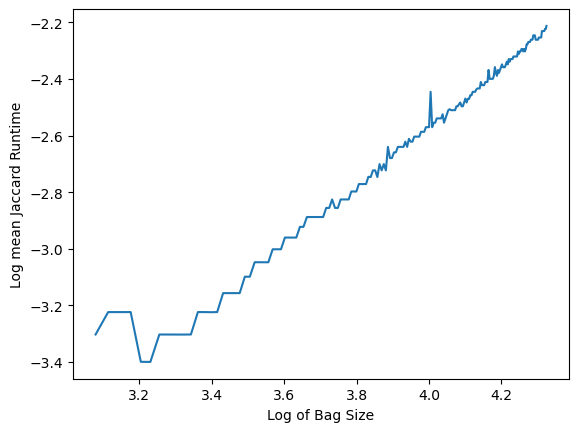

In [25]:
# Converting each item in the bag size and run time lists to logarithmic values with base 10
logx = [ npy.log10(i )for i in x]
logy = [npy.log10(i) for i in y]
# making a graph between log values
mplt.plot(logx,logy)
mplt.ylabel("Log mean Jaccard Runtime")
mplt.xlabel('Log of Bag Size')
mplt.show()

In [238]:
slope_jaccard,intercept, r_value, p_value ,std_err = stats.linregress(logx,logy)
constant = npy.power(10,intercept)
print("The slope is {} and Constant for computation is {}".format(slope_jaccard,constant))

The slope is 0.9932317799784333 and Constant for computation is 2.877083529371713e-07


Overall, the graph tells us that the more data we have to compare, the longer it will take to figure out how similarity between them. If we're working with a really big bunch of data, we should be ready for it to take more time to do this comparison. 







# Question 3

All Pair Similarities for Jaccard and cosine similarity measure and theoretical worst case

The following teps together give us a good way to check how well different methods work for finding the similaity of doccumens. This is really important for jobs like searching for documents, grouping them together, or suggesting things to people, especially when we use computers to help us with big sets of information.

In [239]:
def all_pair_similarity_jaccard(a,b):
    for i in range(b):
        for j in range(i+1,b):   # Ensure that we only compare each pair once
            jaccard(data.iloc[0:a+1,i].to_dict(),data.iloc[0:a+1,j].to_dict())

In [240]:
def all_pair_similarity_jaccard_numpy(a,b):
    for i in range(b):
        for j in range(i+1,b):
            jaccard_numpy(data.iloc[0:a+1,i].values,data.iloc[0:a+1,j].values)

In [241]:
def all_pair_similarity_cosine(a,b):
    for i in range((b)):
        for j in range(i+1,(b)):
            cosine(data.iloc[:a+1,i].values,data.iloc[:a+1,j].values)

In [242]:
def all_pair_similarity_cosine_numpy(a,b):
    for i in range((b)):
        for j in range(i+1,(b)):
            cosine_numpy(data.iloc[:a+1,i].values,data.iloc[:a+1,j].values)

In [243]:
bs = []
y_cosine_numpy = []

for b in range(1,20):
    bs.append(b)
    (mean_cosine_numpy,std_m) = timeit(all_pair_similarity_cosine_numpy,2000,b,repeats=10)
    
    y_cosine_numpy.append(mean_cosine_numpy)
    
print(y_cosine_numpy)   

[0.0, 9.963512420654296e-05, 0.00019936561584472657, 0.0004982709884643555, 0.0006976127624511719, 0.0009962558746337891, 0.001495027542114258, 0.0019938468933105467, 0.0025907516479492187, 0.0032892942428588865, 0.003886985778808594, 0.004584670066833496, 0.00538167953491211, 0.006378602981567383, 0.007375288009643555, 0.008272314071655273, 0.009667611122131348, 0.01076362133026123, 0.011910772323608399]


In [244]:
bs = []
y_cosine = []

for b in range(1,20):
    bs.append(b)
    (mean_cosine,std_m) = timeit(all_pair_similarity_cosine,2000,b,repeats=10)
    
    y_cosine.append(mean_cosine)
    
print(y_cosine)

[0.0, 0.0009093284606933594, 0.0023923397064208986, 0.003587937355041504, 0.005979990959167481, 0.009667372703552246, 0.012657570838928222, 0.01731870174407959, 0.02232532501220703, 0.02770707607269287, 0.033986258506774905, 0.0400658130645752, 0.047843432426452635, 0.05481641292572022, 0.06249446868896484, 0.07246778011322022, 0.08421905040740967, 0.09388558864593506, 0.10455245971679687]


In [245]:
bs = []
y_jaccard_numpy = []

for b in range(1,20):
    bs.append(b)
    (mean_jaccard_numpy,std_m) = timeit(all_pair_similarity_jaccard_numpy,2000,b,repeats=10)
    
    y_jaccard_numpy.append(mean_jaccard_numpy)

print(y_jaccard_numpy) 

[0.0, 0.00019931793212890625, 0.0004982948303222656, 0.0010967493057250977, 0.0007969141006469727, 0.0010967016220092773, 0.001394963264465332, 0.0018939971923828125, 0.0023919820785522463, 0.0029900074005126953, 0.003787517547607422, 0.004385161399841309, 0.005182623863220215, 0.006135129928588867, 0.006986188888549805, 0.008072972297668457, 0.009169268608093261, 0.01036529541015625, 0.01166098117828369]


In [246]:
bs = []
y_jaccard = []

for b in range(1,20):
    bs.append(b)
    (mean_jaccard,std_m) = timeit(all_pair_similarity_jaccard,2000,b,repeats=10)
    
    y_jaccard.append(mean_jaccard)

print(y_jaccard) 

[0.0, 0.0021943569183349608, 0.004784226417541504, 0.009368634223937989, 0.015547895431518554, 0.02342534065246582, 0.03319249153137207, 0.045200538635253903, 0.058603525161743164, 0.0733574390411377, 0.0892247200012207, 0.10660409927368164, 0.12378892898559571, 0.14363689422607423, 0.16649441719055175, 0.19476466178894042, 0.21847503185272216, 0.2468874454498291, 0.27685022354125977]


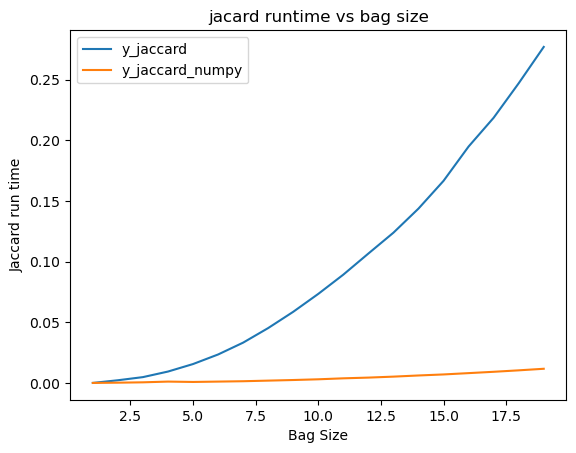

In [247]:
mplt.xlabel('Bag Size')
mplt.ylabel('Jaccard run time')
mplt.title('jacard runtime vs bag size')
mplt.plot(bs,y_jaccard, label="y_jaccard")
mplt.plot(bs,y_jaccard_numpy, label="y_jaccard_numpy")


mplt.legend(loc="best")
mplt.show()

Because our function contains nested loops, it is evident from the graph that the time complexity is quadratic, just like the cosine all pair function, which in this instance should be O(n^2).

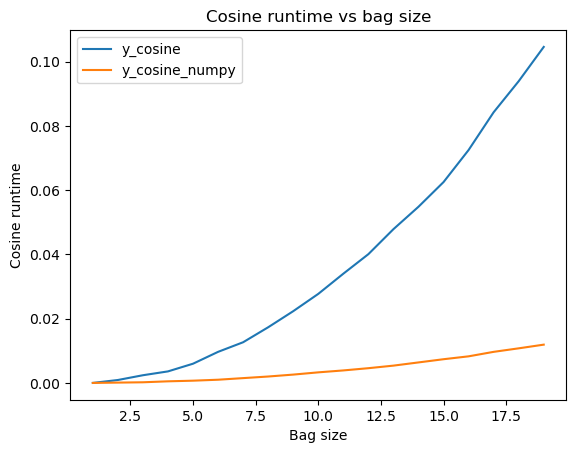

In [248]:
mplt.xlabel('Bag size')
mplt.ylabel('Cosine runtime')
mplt.title('Cosine runtime vs bag size')
mplt.plot(bs,y_cosine, label="y_cosine")
mplt.plot(bs,y_cosine_numpy, label="y_cosine_numpy")


mplt.legend(loc="best")
mplt.show()

Although both similarity functions follow a quadratic relation and have an O(n^2) time complexity due to nested loops, as the document size increases, the all-pair Jaccard similarity function appears to be a little more efficient, as can be seen from the graph. Also the NumPy method for calculating cosine similarity is much faster and is better with larger datasets compared to the other method. 

C:\Users\tg342\AppData\Local\Temp\ipykernel_23000\3650554529.py:2: RuntimeWarning: divide by zero encountered in log10
  logcs=[npy.log10(y) for y in y_cosine]
C:\Users\tg342\AppData\Local\Temp\ipykernel_23000\3650554529.py:3: RuntimeWarning: divide by zero encountered in log10
  logjc=[npy.log10(y) for y in y_jaccard]
C:\Users\tg342\AppData\Local\Temp\ipykernel_23000\3650554529.py:4: RuntimeWarning: divide by zero encountered in log10
  logcsn=[npy.log10(y) for y in y_cosine_numpy]
C:\Users\tg342\AppData\Local\Temp\ipykernel_23000\3650554529.py:5: RuntimeWarning: divide by zero encountered in log10
  logjcn=[npy.log10(y) for y in y_jaccard_numpy]


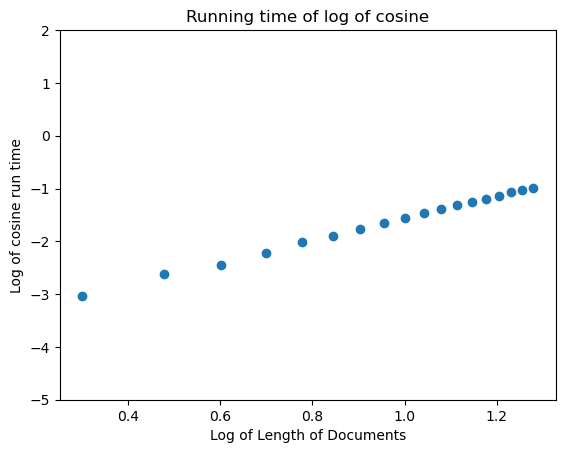

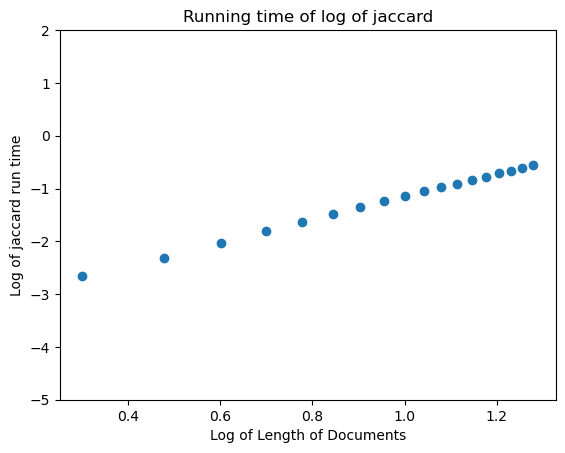

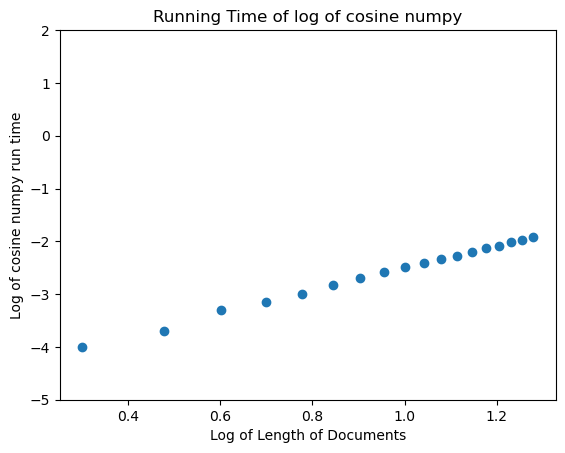

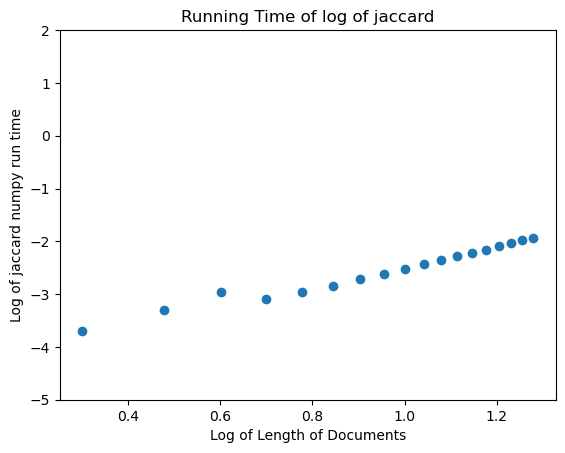

In [249]:
logbs=[npy.log10(b) for b in bs]
logcs=[npy.log10(y) for y in y_cosine]
logjc=[npy.log10(y) for y in y_jaccard]
logcsn=[npy.log10(y) for y in y_cosine_numpy]
logjcn=[npy.log10(y) for y in y_jaccard_numpy]

mplt.scatter(logbs,logcs)
mplt.ylim(-5,2)
mplt.xlabel("Log of Length of Documents")
mplt.ylabel("Log of cosine run time")
mplt.title("Running time of log of cosine")
mplt.show()

mplt.scatter(logbs,logjc)
mplt.ylim(-5,2)
mplt.xlabel("Log of Length of Documents")
mplt.ylabel("Log of jaccard run time")
mplt.title("Running time of log of jaccard")
mplt.show()

mplt.scatter(logbs,logcsn)
mplt.ylim(-5,2)
mplt.xlabel("Log of Length of Documents")
mplt.ylabel("Log of cosine numpy run time")
mplt.title("Running Time of log of cosine numpy")
mplt.show()

mplt.scatter(logxs,logjcn)
mplt.ylim(-5,2)
mplt.xlabel("Log of Length of Documents")
mplt.ylabel("Log of jaccard numpy run time")
mplt.title("Running Time of log of jaccard")
mplt.show()


Since the dataset is containing an infinite value we are here not able to get a proper value for slope. 

## Question 4.


Here we address the challenge of efficiently computing the cosine similarity across all pairs of columns in a dataset, an operation that is common in tasks involving large datasets. The code  a multithreaded approach to parallelize the computation, significantly reducing the processing time when compared to sequential execution.

In [251]:
def cosine_similarity(vec1, vec2):       #his function calculates the cosine similarity between two vectors
    dot_product = npy.dot(vec1, vec2)
    norm_vec1 = npy.linalg.norm(vec1)
    norm_vec2 = npy.linalg.norm(vec2)
   
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

def compute_column_similarity(pair, result_matrix, data):  #computes the cosine similarity for a pair of columns in the dataset
    col1, col2 = pair
    result_matrix[col1, col2] = cosine_similarity(data[:, col1], data[:, col2])
    result_matrix[col2, col1] = result_matrix[col1, col2]


def all_columns_similarity_multithreaded(data, num_threads):  #This function is designed to calculate the cosine similarities for all pairs of columns using multiple threads to speed up the process
    num_columns = data.shape[1]
    result_matrix = npy.zeros((num_columns, num_columns))
    threads = []

    for col1 in range(num_columns):
        for col2 in range(col1 + 1, num_columns):
            pair = (col1, col2)
            thread = threading.Thread(target=compute_column_similarity, args=(pair, result_matrix, data))
            thread.start()
            threads.append(thread)

    for thread in threads:
        thread.join()

    return result_matrix

def measure_execution_time(data, num_threads):    # measures the time it takes to compute all the similarities 
    start_time = time.time()
    _ = all_columns_similarity_multithreaded(data, num_threads)
    execution_time = time.time() - start_time    #total execution time for computing the similarities.
    return execution_time

# Example usage for measuring execution time and plotting
data = data1.iloc[:,1:].values  # Replace with your data (50 rows, 100 columns)

num_threads_list = [1,2,3,4,5,6]
  # List of thread counts to test
parallel_execution_times = []

for num_threads in num_threads_list:
    execution_time = measure_execution_time(data, num_threads)
    parallel_execution_times.append(execution_time)
    print(f"Thread: {num_threads}, Execution Time: {execution_time} seconds")


Thread: 1, Execution Time: 0.03189682960510254 seconds
Thread: 2, Execution Time: 0.022922992706298828 seconds
Thread: 3, Execution Time: 0.021926403045654297 seconds
Thread: 4, Execution Time: 0.023920059204101562 seconds
Thread: 5, Execution Time: 0.02391982078552246 seconds
Thread: 6, Execution Time: 0.021036386489868164 seconds


This code would be useful for someone who has a large dataset and wants to calculate the similarity between each pair of columns quickly by using multiple threads to do many calculations at the same time.

## Question 5.

Using Strassen’s method for matrix multiplication and calculating similarity.

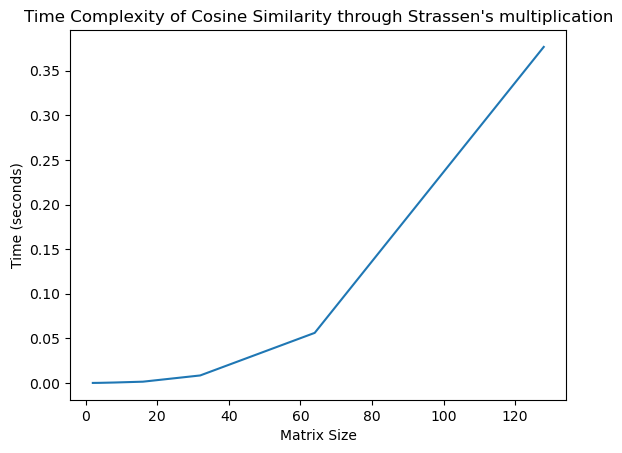

In [37]:
def segment(M):
    (mm,nn)=npy.shape(M)
    n = int(mm/2)
   
    a=M[:n,:n]
    b=M[:n,n:]
    c=M[n:,:n]
    d=M[n:,n:]
   
    return (a,b,c,d)

#This function segment divides a matrix M into four submatrices, a, b, c, and d, by doing a 2x2 segmentation of the matrix

def build(a,b,c,d):
   
    (mm,nn)=npy.shape(a)
    C=npy.zeros([2*mm,2*mm])
   
    C[:mm,:mm]=a
    C[:mm,mm:]=b
    C[mm:,:mm]=c
    C[mm:,mm:]=d
           
    return C

#Four matrices are passed into the function build, which arranges them in a particular way to create a larger matrix, C


def strassen(M1, M2):
   
    if len(M1) <= 2:
        return npy.matmul(M1,M2) #using Matmul the inbuilt function of Numpy
   
    (a,b,c,d) = segment(M1)

    #note: e g f h NOT e f g h
    (e,g,f,h) = segment(M2)

    P1 = strassen(a, g-h)
    P2 = strassen(a+b, h)
    P3 = strassen(c+d,e)
    P4 = strassen(d,f-e)
    P5 = strassen(a+d,e+h)
    P6 = strassen(b-d,f+h)
    P7 = strassen(a-c,e+g)
   
    r = P5+P4-P2+P6
    s = P1+P2
    t = P3+P4
    u = P5-P3-P7+P1
   
    C = build(r,s,t,u)
   
    return C

#It takes two matrices divides them recursively into four quadrants,
#computes intermediate products with seven recursive operations (P1 through P7),
#and uses these intermediate products to build the resultant matrix C.


def cosine_strassen(data):
   
    D = data
    DT = D.transpose()
    products = strassen(DT,D)
    (r,c) = npy.shape(products)
    sims = npy.zeros([r,r])
   
    for i in range(r):
        for j in range(i,r):
            if products[i,i] == 0 or products[j,j] == 0:
                sims[i,j] == sims[j,i] == 0
            else:
                sims[i,j] = products[i,j]/math.sqrt(products[i,i]*products[j,j])
                sims[j,i] = products[j,i]/math.sqrt(products[i,i]*products[j,j])
   
    return sims

#This code implements cosine all pair similarity without using the dot function but integrating strassen method to do so
transposed_df =data1.transpose()
newdata=transposed_df.values
newdata

#Converting to numpy array for ease of operations
sample =newdata[:,:500] # Slicing the rows as well to make a square matrix
for n in range(4):
   
    sample = npy.concatenate([sample, sample])
   
   
i = 1
n = 2**i # It starts with a matrix of size 2x2 and iteratively doubles the size until it reaches 128x128
stressensizes = [] # to store ste size of each cycle
stressentimes = [] # to store mean time of each cycle

while(n <= 128): #looping upto 128
    stressensizes.append(n)
    (mean, stdev) = timeit(cosine_strassen,sample[:n,:n],repeats = 10)
    stressentimes.append(mean)
    i += 1
    n = 2**i  
   
   
mplt.plot(stressensizes , stressentimes)
mplt.xlabel('Matrix Size')
mplt.ylabel('Time (seconds)')
mplt.title("Time Complexity of Cosine Similarity through Strassen's multiplication")
mplt.show()    

Here from the graph it is evident that this meethod is more efficient as the size of the matrices increases. This means that when working with large datasets that require matrix operations, using Strassen's method can save time and computational resources. It's a good choice for handling big calculations.

# CONCLUSION

Overall, our research examined various approaches for determining similarity or difference between two sets of data and how to perform these comparisons more quickly and efficiently. We found that the more data we have, the longer it takes to compare things. However, the Jaccard method performs slightly better in large amounts of data. If the data is complex or there are a lot of them, it takes a lot longer to compare every conceivable pair. It can be sped up by using greater computer power to perform multiple comparisons at once. Furthermore, Strassen's technique, which becomes more efficient with increasing data volumes, performs exceptionally well for large scale comparisons. The optimal approach may vary depending on the type of data you possess.

In [39]:
filepath="3Mreport.ipynb"
import io
from nbformat import read
with io.open(filepath, "r", encoding="utf-8") as f:
    nb=read(f, 4)
word_count = 0
for cell in nb["cells"]:
    if cell.cell_type == "markdown":
        word_count += len(cell["source"].replace("#", "").lstrip().split(" "))
print(f"Submission length is {word_count}")

Submission length is 1358
